In [1]:
import pandas as pd
import operator as op
from functools import reduce
import numpy as np
pd.set_option("display.max_rows", 101)
import matplotlib. pyplot as plt

1. Import confirmed, recovered and deaths data set for a given country

In [2]:
confirmed = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
deaths = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

#### Figure 2: Data cleaning, negative values

In [3]:
#deaths[deaths['Country/Region'] == 'France'].iloc[:,4:].T.diff().sum(axis=1).plot(title='Daily Deaths in France')

In [4]:
def reformat(df, country, col_name):
    
    df = df[df['Country/Region'] == country]
    df = df.T
    df = df.iloc[4:,:]

    
    return pd.DataFrame({col_name: df.sum(axis=1)})

    #df = df[df[col_name] > 0]

country = 'Switzerland'

recovered = reformat(recovered, country, 'Recovered cases')
confirmed = reformat(confirmed, country, 'Confirmed cases')
deaths = reformat(deaths, country, 'Deaths cases')

recovered.tail()

,Recovered cases
7/7/20,29300.0
7/8/20,29400.0
7/9/20,29400.0
7/10/20,29400.0
7/11/20,29500.0


3. Create new data frame recovered per day so we know how many people recovered from the epidemic on a given day


**problem** : Here, I see that recovered_daily contains a negative value, therefore recovered is not fully incremental. ??? Change dataset?

In [5]:
recovered_daily = recovered.diff()
recovered_daily.iloc[0,:] = 0

deaths_daily = deaths.diff()
deaths_daily.iloc[0] = 0

4. Generate dataset infected representing the number of infected individuals at a given time t (not the new number of infected, number of actively infected individuals)

$$\text{confirmed}(t)=\text{confirmed}(t)-\sum_{i=\text{day}_0}^{t}\text{recovered_daily(i)}-\sum_{i=\text{day}_0}^{t}\text{deaths_daily}(i)$$

In [7]:
infected_ = []
days_ = []
# i: date (time t)
# row: row
acc_deaths = 0
acc_recovered = 0

for i, row in confirmed.iterrows():
    acc_recovered += recovered_daily.loc[i]['Recovered cases']
    acc_deaths += deaths_daily.loc[i]['Deaths cases']
    
    diff = row['Confirmed cases'] - acc_recovered - acc_deaths
    
    infected_.append(diff)
    days_.append(i)

Careful, infected represents active number of infected, not new number of infected

In [8]:
infected = pd.DataFrame({'Date': days_,'Infected Cases': infected_})

recovered = recovered.reset_index().rename({'index':'Date'}, axis = 1)

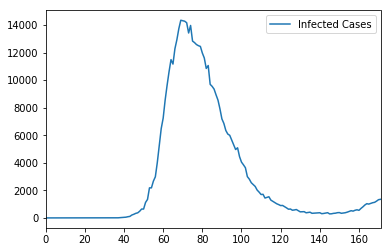

In [9]:
infected.plot()

[Text(0.5, 0, 'Number of individuals recovered')]

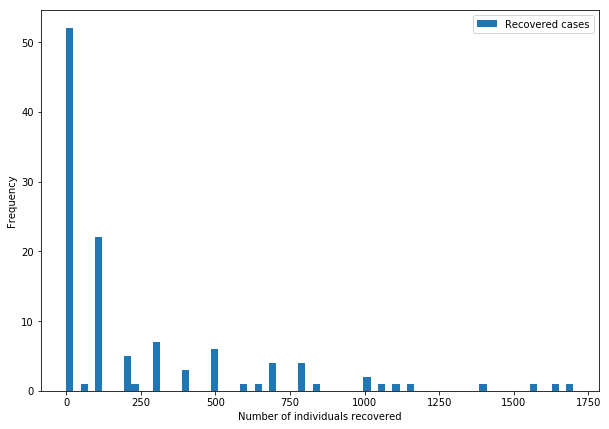

In [10]:
ax = pd.DataFrame(recovered['Recovered cases'].diff()).iloc[55:,:].plot.hist(bins=70,figsize=(10,7))
ax.set(xlabel="Number of individuals recovered")
#pd.DataFrame(recovered['Recovered cases'].diff()).iloc[55:,:].plot.hist(xlabel="Number of Recovered")
#(title="Frequency per number of daily recovered counted since 55th day (March 17th)")#.groupby()
# in order to see zeros from when people started recovering

[Text(0.5, 0, 'Day')]

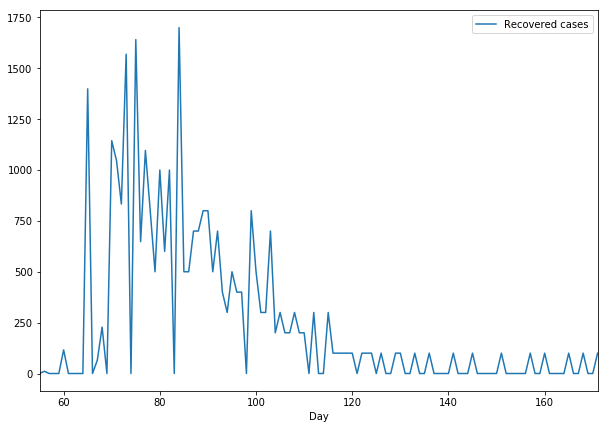

In [11]:
ax = pd.DataFrame(recovered['Recovered cases'].diff()).iloc[55:,:].plot(figsize=(10,7))
ax.set(xlabel='Day')

Now we can start working on predicting our gammas. 
Recovered is cumulative, as expected (absorbing state in our SIR model) and infected represents the number of infected individual at a certain date

In [12]:
data = recovered.merge(infected, on='Date')

data['Date'] = pd.to_datetime(data['Date'])
#df['DOB'] = pd.to_datetime(df.DOB)

data = data.set_index('Date')
data['Recovered Daily'] = recovered_daily
data['Deaths Daily'] = deaths_daily

data = data[['Infected Cases', 'Recovered Daily', 'Deaths Daily']]
data.head()

,Infected Cases,Recovered Daily,Deaths Daily
Date,,,
2020-01-22,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0


[Text(0.5, 0, 'Day')]

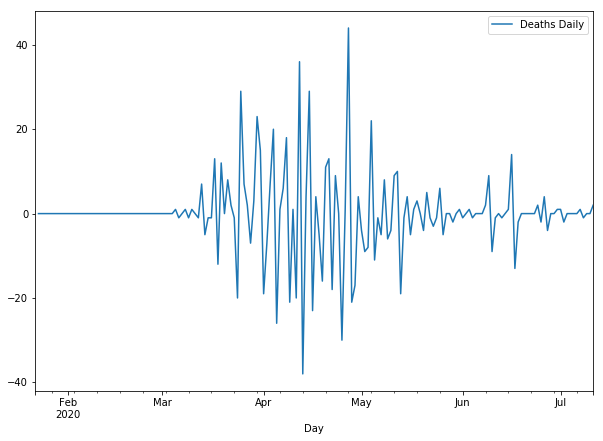

In [13]:
ax = pd.DataFrame(data['Deaths Daily'].diff()).plot(figsize=(10,7))
ax.set(xlabel='Day')

## Create X and y to export data

### Run this if input from $t-1$ to $t-7$ 0.91

In [14]:
data1 = data

In [15]:
data1 = data1.reset_index()

In [16]:
"""data1 = data1.reset_index()

dataframe = pd.concat([data1['Date'],data1['Recovered Daily'], data1['Deaths Daily'],
                       data1['Infected Cases'].shift(1),data1['Infected Cases'].shift(2),
                       data1['Infected Cases'].shift(3),data1['Infected Cases'].shift(4),data1['Infected Cases'].shift(5),data1['Infected Cases'].shift(6),data1['Infected Cases'].shift(7)], axis=1)

# create lagged dataset
dataframe.columns = ['Date', 'Recovered Daily', 'Deaths Daily',
                    'Infected cases t-1','Infected cases t-2','Infected cases t-3','Infected cases t-4',
                    'Infected cases t-5', 'Infected cases t-6', 'Infected cases t-7']

# Keep data such that we have value t-21 at any given day t
dataframe = dataframe[~np.isnan(dataframe['Infected cases t-7'])]
"""

"data1 = data1.reset_index()\n\ndataframe = pd.concat([data1['Date'],data1['Recovered Daily'], data1['Deaths Daily'],\n                       data1['Infected Cases'].shift(1),data1['Infected Cases'].shift(2),\n                       data1['Infected Cases'].shift(3),data1['Infected Cases'].shift(4),data1['Infected Cases'].shift(5),data1['Infected Cases'].shift(6),data1['Infected Cases'].shift(7)], axis=1)\n\n# create lagged dataset\ndataframe.columns = ['Date', 'Recovered Daily', 'Deaths Daily',\n                    'Infected cases t-1','Infected cases t-2','Infected cases t-3','Infected cases t-4',\n                    'Infected cases t-5', 'Infected cases t-6', 'Infected cases t-7']\n\n# Keep data such that we have value t-21 at any given day t\ndataframe = dataframe[~np.isnan(dataframe['Infected cases t-7'])]\n"

### Run this if input from $t-7$ to $t-10$ 1.11

In [17]:
#data1 = data1.reset_index()

dataframe = pd.concat([data1['Date'],data1['Recovered Daily'], data1['Deaths Daily'],
                       data1['Infected Cases'].shift(7),data1['Infected Cases'].shift(8),
                       data1['Infected Cases'].shift(9),data1['Infected Cases'].shift(10)], axis=1)

# create lagged dataset
dataframe.columns = ['Date', 'Recovered Daily', 'Deaths Daily',
                    'Infected cases t-7','Infected cases t-8','Infected cases t-9','Infected cases t-10']

# Keep data such that we have value t-21 at any given day t
dataframe = dataframe[~np.isnan(dataframe['Infected cases t-10'])]

### Run this if input from $t-14$ to $t-21$ MAPE=0.86

In [18]:
"""#data1 = data1.reset_index()

dataframe = pd.concat([data1['Date'],data1['Recovered Daily'], data1['Deaths Daily'],
                       data1['Infected Cases'].shift(14),data1['Infected Cases'].shift(15),
                       data1['Infected Cases'].shift(16),data1['Infected Cases'].shift(17),
                       data1['Infected Cases'].shift(18),data1['Infected Cases'].shift(19),data1['Infected Cases'].shift(20),
                      data1['Infected Cases'].shift(21)], axis=1)

# create lagged dataset
dataframe.columns = ['Date', 'Recovered Daily', 'Deaths Daily',
                    'Infected cases t-14','Infected cases t-15','Infected cases t-16','Infected cases t-17',
                    'Infected cases t-18', 'Infected cases t-19', 'Infected cases t-20', 'Infected cases t-21']

# Keep data such that we have value t-21 at any given day t
dataframe = dataframe[~np.isnan(dataframe['Infected cases t-21'])]"""

"#data1 = data1.reset_index()\n\ndataframe = pd.concat([data1['Date'],data1['Recovered Daily'], data1['Deaths Daily'],\n                       data1['Infected Cases'].shift(14),data1['Infected Cases'].shift(15),\n                       data1['Infected Cases'].shift(16),data1['Infected Cases'].shift(17),\n                       data1['Infected Cases'].shift(18),data1['Infected Cases'].shift(19),data1['Infected Cases'].shift(20),\n                      data1['Infected Cases'].shift(21)], axis=1)\n\n# create lagged dataset\ndataframe.columns = ['Date', 'Recovered Daily', 'Deaths Daily',\n                    'Infected cases t-14','Infected cases t-15','Infected cases t-16','Infected cases t-17',\n                    'Infected cases t-18', 'Infected cases t-19', 'Infected cases t-20', 'Infected cases t-21']\n\n# Keep data such that we have value t-21 at any given day t\ndataframe = dataframe[~np.isnan(dataframe['Infected cases t-21'])]"

### Run this if input is from $t-7$ to $t-21$ 0.71

In [19]:
data1 = data1.reset_index()

dataframe = pd.concat([data1['Date'],data1['Recovered Daily'], data1['Deaths Daily'],data1['Infected Cases'].shift(7),
                       data1['Infected Cases'].shift(8),data1['Infected Cases'].shift(9),
                       data1['Infected Cases'].shift(10),data1['Infected Cases'].shift(11),
                       data1['Infected Cases'].shift(12),data1['Infected Cases'].shift(13),
                       data1['Infected Cases'].shift(14),data1['Infected Cases'].shift(15),
                       data1['Infected Cases'].shift(16),data1['Infected Cases'].shift(17),
                       data1['Infected Cases'].shift(18),data1['Infected Cases'].shift(19),
                       data1['Infected Cases'].shift(20),data1['Infected Cases'].shift(21)], axis=1)

# create lagged dataset
dataframe.columns = ['Date', 'Recovered Daily', 'Deaths Daily','Infected cases t-7','Infected cases t-8','Infected cases t-9',
                    'Infected cases t-10','Infected cases t-11','Infected cases t-12','Infected cases t-13',
                    'Infected cases t-14','Infected cases t-15','Infected cases t-16','Infected cases t-17',
                    'Infected cases t-18','Infected cases t-19','Infected cases t-20','Infected cases t-21']

# Keep data such that we have value t-21 at any given day t
dataframe = dataframe[~np.isnan(dataframe['Infected cases t-21'])]

### Run this if input from $t-1$ to $t-14$ MEDIUM best off MAPE 0.88

In [20]:
"""#data1 = data1.reset_index()

dataframe = pd.concat([data1['Date'],data1['Recovered Daily'], data1['Deaths Daily'],data1['Infected Cases'].shift(1),
                       data1['Infected Cases'].shift(2),data1['Infected Cases'].shift(3),
                       data1['Infected Cases'].shift(4),data1['Infected Cases'].shift(5),
                       data1['Infected Cases'].shift(6),data1['Infected Cases'].shift(7),
                       data1['Infected Cases'].shift(8),data1['Infected Cases'].shift(9),
                       data1['Infected Cases'].shift(10),data1['Infected Cases'].shift(11),
                       data1['Infected Cases'].shift(12),data1['Infected Cases'].shift(13),
                       data1['Infected Cases'].shift(14)], axis=1)

# create lagged dataset
dataframe.columns = ['Date', 'Recovered Daily', 'Deaths Daily','Infected cases t-1','Infected cases t-2','Infected cases t-3',
                    'Infected cases t-4','Infected cases t-5','Infected cases t-6','Infected cases t-7','Infected cases t-8','Infected cases t-9',
                    'Infected cases t-10','Infected cases t-11','Infected cases t-12','Infected cases t-13',
                    'Infected cases t-14']

# Keep data such that we have value t-21 at any given day t
dataframe = dataframe[~np.isnan(dataframe['Infected cases t-14'])]"""

"#data1 = data1.reset_index()\n\ndataframe = pd.concat([data1['Date'],data1['Recovered Daily'], data1['Deaths Daily'],data1['Infected Cases'].shift(1),\n                       data1['Infected Cases'].shift(2),data1['Infected Cases'].shift(3),\n                       data1['Infected Cases'].shift(4),data1['Infected Cases'].shift(5),\n                       data1['Infected Cases'].shift(6),data1['Infected Cases'].shift(7),\n                       data1['Infected Cases'].shift(8),data1['Infected Cases'].shift(9),\n                       data1['Infected Cases'].shift(10),data1['Infected Cases'].shift(11),\n                       data1['Infected Cases'].shift(12),data1['Infected Cases'].shift(13),\n                       data1['Infected Cases'].shift(14)], axis=1)\n\n# create lagged dataset\ndataframe.columns = ['Date', 'Recovered Daily', 'Deaths Daily','Infected cases t-1','Infected cases t-2','Infected cases t-3',\n                    'Infected cases t-4','Infected cases t-5','Infected ca

### Run this if input from $t-1$ to $t-21$ 0.61

In [21]:
"""#data1 = data1.reset_index()

dataframe = pd.concat([data1['Date'],data1['Recovered Daily'], data1['Deaths Daily'],data1['Infected Cases'].shift(1),
                       data1['Infected Cases'].shift(2),data1['Infected Cases'].shift(3),
                       data1['Infected Cases'].shift(4),data1['Infected Cases'].shift(5),
                       data1['Infected Cases'].shift(6),data1['Infected Cases'].shift(7),
                       data1['Infected Cases'].shift(8),data1['Infected Cases'].shift(9),
                       data1['Infected Cases'].shift(10),data1['Infected Cases'].shift(11),
                       data1['Infected Cases'].shift(12),data1['Infected Cases'].shift(13),
                       data1['Infected Cases'].shift(14),data1['Infected Cases'].shift(15),
                       data1['Infected Cases'].shift(16),data1['Infected Cases'].shift(17),
                       data1['Infected Cases'].shift(18),data1['Infected Cases'].shift(19),
                       data1['Infected Cases'].shift(20),data1['Infected Cases'].shift(21)], axis=1)

# create lagged dataset
dataframe.columns = ['Date', 'Recovered Daily', 'Deaths Daily','Infected cases t-1','Infected cases t-2','Infected cases t-3',
                    'Infected cases t-4','Infected cases t-5','Infected cases t-6','Infected cases t-7','Infected cases t-8','Infected cases t-9',
                    'Infected cases t-10','Infected cases t-11','Infected cases t-12','Infected cases t-13',
                    'Infected cases t-14','Infected cases t-15','Infected cases t-16','Infected cases t-17',
                    'Infected cases t-18','Infected cases t-19','Infected cases t-20','Infected cases t-21']

# Keep data such that we have value t-21 at any given day t
dataframe = dataframe[~np.isnan(dataframe['Infected cases t-21'])]"""

"#data1 = data1.reset_index()\n\ndataframe = pd.concat([data1['Date'],data1['Recovered Daily'], data1['Deaths Daily'],data1['Infected Cases'].shift(1),\n                       data1['Infected Cases'].shift(2),data1['Infected Cases'].shift(3),\n                       data1['Infected Cases'].shift(4),data1['Infected Cases'].shift(5),\n                       data1['Infected Cases'].shift(6),data1['Infected Cases'].shift(7),\n                       data1['Infected Cases'].shift(8),data1['Infected Cases'].shift(9),\n                       data1['Infected Cases'].shift(10),data1['Infected Cases'].shift(11),\n                       data1['Infected Cases'].shift(12),data1['Infected Cases'].shift(13),\n                       data1['Infected Cases'].shift(14),data1['Infected Cases'].shift(15),\n                       data1['Infected Cases'].shift(16),data1['Infected Cases'].shift(17),\n                       data1['Infected Cases'].shift(18),data1['Infected Cases'].shift(19),\n                  

### Run this if input is from $t-1$ to $t-30$

In [22]:
data1 = data1.reset_index()

dataframe = pd.concat([data1['Date'],data1['Recovered Daily'], data1['Deaths Daily'], data1['Infected Cases'].shift(1),
                       data1['Infected Cases'].shift(2),data1['Infected Cases'].shift(3),data1['Infected Cases'].shift(4),
                       data1['Infected Cases'].shift(5),data1['Infected Cases'].shift(6),data1['Infected Cases'].shift(7),
                       data1['Infected Cases'].shift(8),data1['Infected Cases'].shift(9),
                       data1['Infected Cases'].shift(10),data1['Infected Cases'].shift(11),
                       data1['Infected Cases'].shift(12),data1['Infected Cases'].shift(13),
                       data1['Infected Cases'].shift(14),data1['Infected Cases'].shift(15),
                       data1['Infected Cases'].shift(16),data1['Infected Cases'].shift(17),
                       data1['Infected Cases'].shift(18),data1['Infected Cases'].shift(19),
                       data1['Infected Cases'].shift(20),data1['Infected Cases'].shift(21),
                       data1['Infected Cases'].shift(22),data1['Infected Cases'].shift(23),
                       data1['Infected Cases'].shift(24),data1['Infected Cases'].shift(25),
                       data1['Infected Cases'].shift(26),data1['Infected Cases'].shift(27),
                       data1['Infected Cases'].shift(28),data1['Infected Cases'].shift(29),
                       data1['Infected Cases'].shift(30)], axis=1)

# create lagged dataset
dataframe.columns = ['Date', 'Recovered Daily', 'Deaths Daily','Infected cases t-1','Infected cases t-1','Infected cases t-2',
                     'Infected cases t-4','Infected cases t-5','Infected cases t-6','Infected cases t-7','Infected cases t-8','Infected cases t-9',
                    'Infected cases t-10','Infected cases t-11','Infected cases t-12','Infected cases t-13',
                    'Infected cases t-14','Infected cases t-15','Infected cases t-16','Infected cases t-17',
                    'Infected cases t-18','Infected cases t-19','Infected cases t-20','Infected cases t-21',
                    'Infected cases t-22','Infected cases t-23','Infected cases t-24','Infected cases t-25','Infected cases t-26'
                    ,'Infected cases t-27','Infected cases t-28','Infected cases t-29','Infected cases t-30']

# Keep data such that we have value t-21 at any given day t
dataframe = dataframe[~np.isnan(dataframe['Infected cases t-30'])]

### t-7 to t-28

In [23]:
"""#data1 = data1.reset_index()

dataframe = pd.concat([data1['Date'],data1['Recovered Daily'], data1['Deaths Daily'], data1['Infected Cases'].shift(7),
                       data1['Infected Cases'].shift(8),data1['Infected Cases'].shift(9),
                       data1['Infected Cases'].shift(10),data1['Infected Cases'].shift(11),
                       data1['Infected Cases'].shift(12),data1['Infected Cases'].shift(13),
                       data1['Infected Cases'].shift(14),data1['Infected Cases'].shift(15),
                       data1['Infected Cases'].shift(16),data1['Infected Cases'].shift(17),
                       data1['Infected Cases'].shift(18),data1['Infected Cases'].shift(19),
                       data1['Infected Cases'].shift(20),data1['Infected Cases'].shift(21),
                       data1['Infected Cases'].shift(22),data1['Infected Cases'].shift(23),
                       data1['Infected Cases'].shift(24),data1['Infected Cases'].shift(25),
                       data1['Infected Cases'].shift(26),data1['Infected Cases'].shift(27),
                       data1['Infected Cases'].shift(28)], axis=1)

# create lagged dataset
dataframe.columns = ['Date', 'Recovered Daily', 'Deaths Daily','Infected cases t-7','Infected cases t-8','Infected cases t-9',
                    'Infected cases t-10','Infected cases t-11','Infected cases t-12','Infected cases t-13',
                    'Infected cases t-14','Infected cases t-15','Infected cases t-16','Infected cases t-17',
                    'Infected cases t-18','Infected cases t-19','Infected cases t-20','Infected cases t-21',
                    'Infected cases t-22','Infected cases t-23','Infected cases t-24','Infected cases t-25','Infected cases t-26'
                    ,'Infected cases t-27','Infected cases t-28']

# Keep data such that we have value t-21 at any given day t
dataframe = dataframe[~np.isnan(dataframe['Infected cases t-28'])]"""

"#data1 = data1.reset_index()\n\ndataframe = pd.concat([data1['Date'],data1['Recovered Daily'], data1['Deaths Daily'], data1['Infected Cases'].shift(7),\n                       data1['Infected Cases'].shift(8),data1['Infected Cases'].shift(9),\n                       data1['Infected Cases'].shift(10),data1['Infected Cases'].shift(11),\n                       data1['Infected Cases'].shift(12),data1['Infected Cases'].shift(13),\n                       data1['Infected Cases'].shift(14),data1['Infected Cases'].shift(15),\n                       data1['Infected Cases'].shift(16),data1['Infected Cases'].shift(17),\n                       data1['Infected Cases'].shift(18),data1['Infected Cases'].shift(19),\n                       data1['Infected Cases'].shift(20),data1['Infected Cases'].shift(21),\n                       data1['Infected Cases'].shift(22),data1['Infected Cases'].shift(23),\n                       data1['Infected Cases'].shift(24),data1['Infected Cases'].shift(25),\n           

In [24]:
dataframe = dataframe.set_index('Date')

### Delete Noisy Data

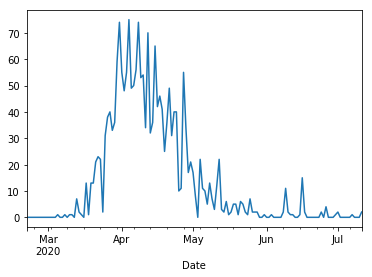

In [25]:
dataframe['Deaths Daily'].plot()

In [26]:
dataframe_new = dataframe.iloc[0:,:].copy()

In [27]:
y_recovered = dataframe_new['Recovered Daily']
y_deaths = dataframe_new['Deaths Daily']
X = dataframe_new.iloc[:,2:]

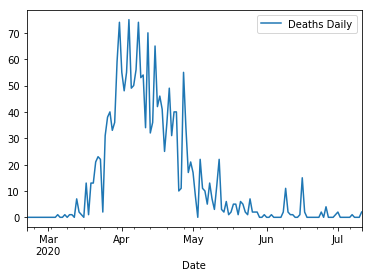

In [28]:
pd.DataFrame(y_deaths).plot()

In [29]:
def exponential_smoothing(y, rho, K):
    const = (1-rho)/(1-rho**(K+1))
    new_y = []
    
    # range of x
    r_y = np.arange(K, len(y)-K)

    # range of k
    r_k = np.arange(0,K)
    
    for i in range(len(y)):
        if i not in r_y:
            new_y.append(y[i])
        else:
            ls = []
            for k in r_k:
                ls.append(int(const*rho**k*y[i-k]))
            new_y.append(np.sum(ls))
                
    return new_y

### Apply changes on Dataframe when recovered value equals 0

In [30]:
df = dataframe_new.copy()

In [31]:
def smooth_y(df, col):    
    # don't forget to round up
    out = df[col].reset_index()
    #for i, el in recovered.iterrows():
    #for i in range(recovered.shape[0]-1):
    i = 0

    # ignore last two elements from list as they are equal to zero so we cannot smooth them
    while(i < out.shape[0]-8):
        if (i > 24) & (out.iloc[i][col] == 0):
            j = 0
            denom = 1
            acc = 0
            while(out.iloc[i+j][col] == 0):
                j+=1
                denom+=1
            div = np.ceil(out.iloc[i+j][col]/denom)
            out.iloc[i:i+j+1,1] = div
            i +=j
        elif out.iloc[i][col] < 0:
            out.iloc[i,out.columns.get_loc(col)] = 1
            i +=1
        else:
            i+=1
            
    out = out.replace(0,1)
    return out

y_recovered_smoothed = smooth_y(df, 'Recovered Daily').set_index('Date').rename({'Recovered Daily': 'Recovered Daily Smoothed'}, axis=1)

y_deaths_smoothed = smooth_y(df, 'Deaths Daily').set_index('Date').rename({'Deaths Daily': 'Deaths Daily Smoothed'}, axis=1)

y_deaths = y_deaths_smoothed['Deaths Daily Smoothed'].to_list()

y_deaths_smoothed['Deaths Daily Smoothed'] = exponential_smoothing(y_deaths, 0.65, 7)

y_deaths_smoothed[y_deaths_smoothed['Deaths Daily Smoothed'] < 1] = 1

data = pd.concat([X, y_deaths_smoothed, y_recovered_smoothed], axis=1)

data.to_csv('data.csv')

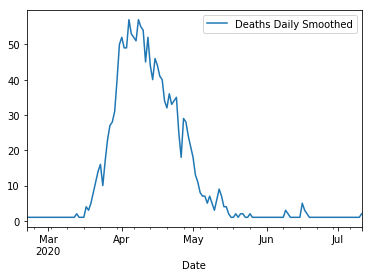

In [32]:
y_deaths_smoothed.plot()

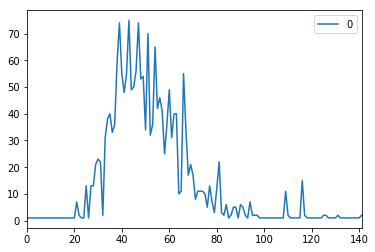

In [33]:
pd.DataFrame(y_deaths).plot()

In [34]:
len(y_deaths)

142

In [35]:
d = {'original':y_deaths, 'smoothed': y_deaths_smoothed}

In [36]:
d

{'original': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  7.0,
  2.0,
  1.0,
  1.0,
  13.0,
  1.0,
  13.0,
  13.0,
  21.0,
  23.0,
  22.0,
  2.0,
  31.0,
  38.0,
  40.0,
  33.0,
  36.0,
  59.0,
  74.0,
  55.0,
  48.0,
  55.0,
  75.0,
  49.0,
  50.0,
  56.0,
  74.0,
  53.0,
  54.0,
  34.0,
  70.0,
  32.0,
  36.0,
  65.0,
  42.0,
  46.0,
  41.0,
  25.0,
  36.0,
  49.0,
  31.0,
  40.0,
  40.0,
  10.0,
  11.0,
  55.0,
  34.0,
  17.0,
  21.0,
  17.0,
  8.0,
  11.0,
  11.0,
  11.0,
  10.0,
  5.0,
  13.0,
  7.0,
  3.0,
  12.0,
  22.0,
  3.0,
  2.0,
  6.0,
  1.0,
  2.0,
  5.0,
  5.0,
  1.0,
  6.0,
  5.0,
  2.0,
  1.0,
  7.0,
  2.0,
  2.0,
  2.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  11.0,
  2.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  15.0,
  2.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  2.0,
  2.0,
  1.0,
  1.0,
  1.0,
  1.0,
  2.0,
  1.0,
  1.

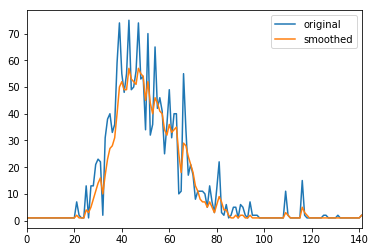

In [37]:
pd.DataFrame({'original':y_deaths, 'smoothed': y_deaths_smoothed['Deaths Daily Smoothed'].values}).plot()

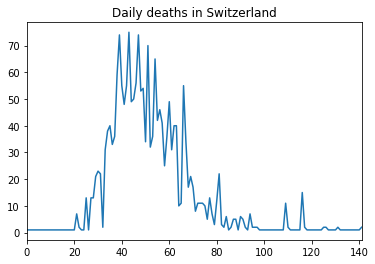

In [38]:
pd.DataFrame(y_deaths).plot(title='Daily deaths in Switzerland', legend=None)


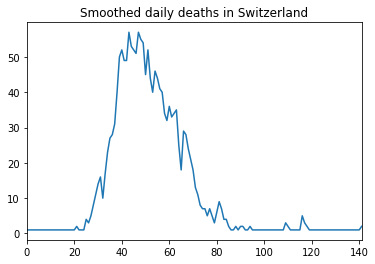

In [39]:
pd.DataFrame(y_deaths_smoothed['Deaths Daily Smoothed'].values).plot(title='Smoothed daily deaths in Switzerland', legend=None)

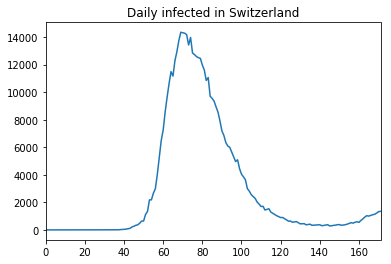

In [40]:
infected['Infected Cases'].plot(title="Daily infected in Switzerland")

In [41]:
pd.DataFrame(gauss_filter(infected['Infected Cases'], 7)).plot(title='Smoothed daily infected in Switzerland', legend=None)

NameError: name 'gauss_filter' is not defined

In [42]:
import numpy as np
from functools import reduce
import operator as op
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

#SMOOTHING#

def gauss_filter(x, K, parity='even'):

    # constant
    A = 2*K
    #upper bound of sum
    B = K
    if parity == 'odd':
        A += 1
        B += 1

    const = 1/(2**A)

    x_filtered = []

    # x elements that will see their value change
    r_x = np.arange(K, len(x)-K)

    # range of k
    r_k = np.arange(-K,B+1)

    for i in range(len(x)):
        if i not in r_x:
            x_filtered.append(x[i])
        else:
            # list on which we will save values to be summed to yield new x_tilde_t
            ls = []
            for k in r_k:
                #x_{t-k}
                comb = ncr(A, K+k)
                #print('i: ',i,'k: ',k)
                x_tk = x[i-k]
                #print(comb, x_tk, comb*x_tk)
                #print(ls)
                ls.append(int(comb*x_tk*const))
                #print(ls)
            x_filtered.append(np.sum(ls))
    return x_filtered

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom
